# 3. Quantify extracellular RNA

After defining extracellular transcripts (previous notebooks), we will now focus on characterizing and quantifying the presence of exRNA for the different genes profiled in the dataset employing different strategies and tests

## Import packages

In [1]:
import spatialdata as sd
import troutpy

/home/sergio/.local/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/home/sergio/.local/lib/python3.10/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)
/home/sergio/.local/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)


## Read the SpatialData object

We read the processed Spatialdata object, which was previously stored as .zarr

In [2]:
xenium_path_cropped = "/media/sergio/Meninges/troutpy/mousebrain_prime_crop_communication.zarr"
sdata = sd.read_zarr(xenium_path_cropped)

## Testing for expression over noise levels

We implemented `troutpy.tl.quantify_overexpression` to identify **overexpressed genes relative to a noise threshold**.

Essentially, it computes a threshold based on the counts of specified control features and compares gene counts against this threshold to determine overexpression. The function calculates log-fold changes for each gene, annotates metadata with these results. It returns updated spatial data along with per-gene scores and the calculated threshold

In [3]:
control_codewords = ["negative_control_probe", "unassigned_codeword", "deprecated_codeword", "genomic_control_probe", "negative_control_codeword"]

troutpy.tl.quantify_overexpression(
    sdata,layer="transcripts",codeword_key="codeword_category",
    control_codewords=control_codewords,gene_key="feature_name",
    percentile_threshold=99.99)

## Testing for proportion of extracellular transcripts

The `troutpy.tl.extracellular_enrichment` function computes the proportions of extracellular and intracellular transcripts for each gene. 

Essentially, the function calculates: (1) the proportion of transcripts of each gene present extracellularly and (2) the log fold change of extracellular to intracellular proportions.  These results into the `sdata` object under the `xrna_metadata` layer.

In [4]:
troutpy.tl.extracellular_enrichment(sdata)

## Testing for Spatial Variability

The `troutpy.tl.spatial_variability` function quantifies the spatial variability of extracellular RNA using Moran's I, a metric for spatial autocorrelation.

In [5]:
troutpy.tl.spatial_variability(sdata, gene_key="feature_name", n_neighbors=10, square_size=20)

Extracting gene counts: 100%|██████████| 13031/13031 [00:00<00:00, 20548.77it/s]


## Testing for local density

The `spatial_colocalization` function evaluates the spatial colocalization of extracellular RNA transcripts in spatial transcriptomics data by identifying regions where transcripts from the same or different genes are found in close proximity. The function calculates the proportion of colocalized transcripts for each gene, using a user-defined threshold to define colocalization, and integrates these results into the metadata of the dataset for downstream analysis.

The function calculates the proportion of colocalized transcripts for each gene based on a user-defined threshold, leveraging kernel density estimation to compute spatial gene expression densities. Results are integrated into the `sdata` object under the `xrna_metadata` layer.

In [6]:
troutpy.tl.spatial_colocalization(
    sdata, coord_keys=["x", "y"], gene_key="feature_name", resolution=1000, square_size=5, threshold_colocalized=1, copy=False
)

Extracting gene counts: 100%|██████████| 13031/13031 [00:07<00:00, 1821.18it/s]


# Intracellular_extracellular_correlation

In [7]:
# this is temporary, since currently extracellular def is wrong on test data
transcripts=sdata['transcripts'].compute() # type: ignore
transcripts['extracellular']=~transcripts['extracellular']
sdata['transcripts'] = sd.models.PointsModel.parse(transcripts)

In [8]:
troutpy.pp.aggregate_extracellular_transcripts(sdata,square_size = 8)
troutpy.tl.in_out_correlation(sdata,n_neighbors=20)

## Save SpatialData as zarr

The resulting dataset is finally stored in a new zarr object

In [10]:
xenium_path_cropped = "/media/sergio/Discovair_final/mousebrain_prime_crop_communication.zarr"
sdata.write(xenium_path_cropped, overwrite=True)

INFO     The SpatialData object is not self-contained (i.e. it contains some elements that are Dask-backed from    
         locations outside /media/sergio/Discovair_final/mousebrain_prime_crop_communication.zarr). Please see the 
         documentation of `is_self_contained()` to understand the implications of working with SpatialData objects 
         that are not self-contained.                                                                              
INFO     The Zarr backing store has been changed from                                                              
         /media/sergio/Discovair_final/mousebrain_prime_crop_communication_2.zarr the new file path:               
         /media/sergio/Discovair_final/mousebrain_prime_crop_communication.zarr                                    


### ---TO DO--- Create visualization for the output of different tests

In [ ]:
xenium_path_cropped = "/media/sergio/Discovair_final/mousebrain_prime_crop_quantified.zarr"
sdata = sd.read_zarr(xenium_path_cropped)

In [ ]:
exrna_metrics = sdata["xrna_metadata"].var
# This ones are the most interesting ones, but others can be used
exrna_metrics_filt = exrna_metrics.loc[:, ["logfoldratio_over_noise", "logfoldratio_extracellular", "moran_I", "proportion_of_colocalized"]]

#### PLOTTING FUNCTION 1 (troutpy.pl)- lfr_over_noise grouped by gene type
- **Aim**: Represent the logfoldratio over noise for different genes
- **Input**: sdata["xrna_metadata"].var
- **Suggested Type of plot**: Either barplot, violin or stripplot, representing logfoldration over noise (`sdata["xrna_metadata"]['logfoldratio_over_noise']`),  grouping genes in based on wether they are control probes or not (in sdata["xrna_metadata"].var['control_probe'] column)
-  **Returns**: None (besides the plot) 

#### PLOTTING FUNCTION 2 (troutpy.pl) Sorted scatterplot/barplot 
- **Aim**: Represent, for a given metric, the genes sorted by them. (the logfoldratio extracellular or extracellular_proportion). Maybe highlighting top-bottom genes with highest-lower scores
- **Input**: sdata -- from which all info needed will be under `sdata["xrna_metadata"].var`, the name column in `sdata["xrna_metadata"].var` (str) (e.g. 'moran_i','extracellular_proportion')
- **Suggested Type of plot**: Either sorted scatter plot, stripplot,barplot or similar, representing extracellular proportion over genes. Maybe color based on  sdata["xrna_metadata"].var['control probe']
- **Return**: None

#### PLOTTING FUNCTION 3 (troutpy.pl)- Scatterplot
- **Aim**: For each gene, represent two of the metrics side by side, in the form of a scatter plot
- **Input**: sdata -- from which all info needed will be under sdata["xrna_metadata"].var, x and y axes
- **Suggested Type of plot**: Scatterplot, maybe colored by control probe column as well
(sdata["xrna_metadata"].var['control probe'])
- **Return**: None

#### PLOTTING FUNCTION 4 (troutpy.pl)- Summary visualization
- **Aim**: Represent in a tabular plot (heatmap, dotplot) the overall score for individual genes on different metrics.
- **Input**: sdata -- from which all info needed will be under `sdata["xrna_metadata"].var`, list of columns in `sdata["xrna_metadata"].var`, maybe list of genes to be visualized? if all are too many.
- **Suggested Type of plot**: Heatmap, dotplot or similar. Take sc.pl.dotplot/ sc.tl.matrixplot as reference?
- **Return**: None

# Filter sdata

In [6]:
troutpy.pp.filter_xrna(sdata,min_logfoldratio_over_noise=3)

# Part 2: Test for diffusion 

We next aim to test if patterns observed outside cells are a consequence or diffussion or not

In [7]:
troutpy.tl.assess_diffussion( sdata, gene_key= "feature_name", distance_key= "distance")

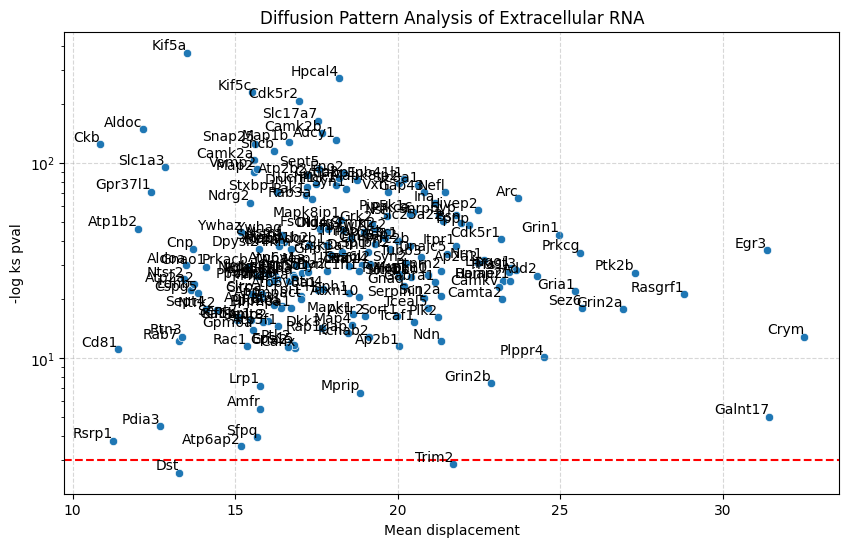

In [8]:
troutpy.pl.diffusion_results(sdata, y_col='-log_ks_pval',y_logscale=True)

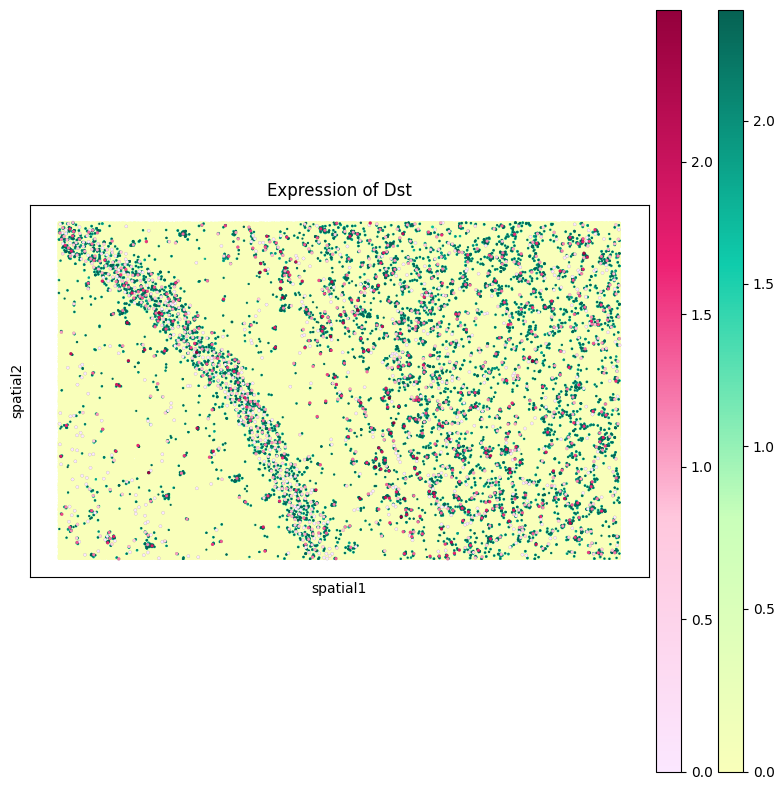

In [24]:
troutpy.pl.spatial_inout_expression(sdata,'Dst',spot_size_cells=6,spot_size_extra=4)

# Cluster distribution from source
Next, we cluster distribution from source to identify genes presenting the same patterns

In [9]:
troutpy.tl.cluster_distribution_from_source(sdata,n_clusters=4)

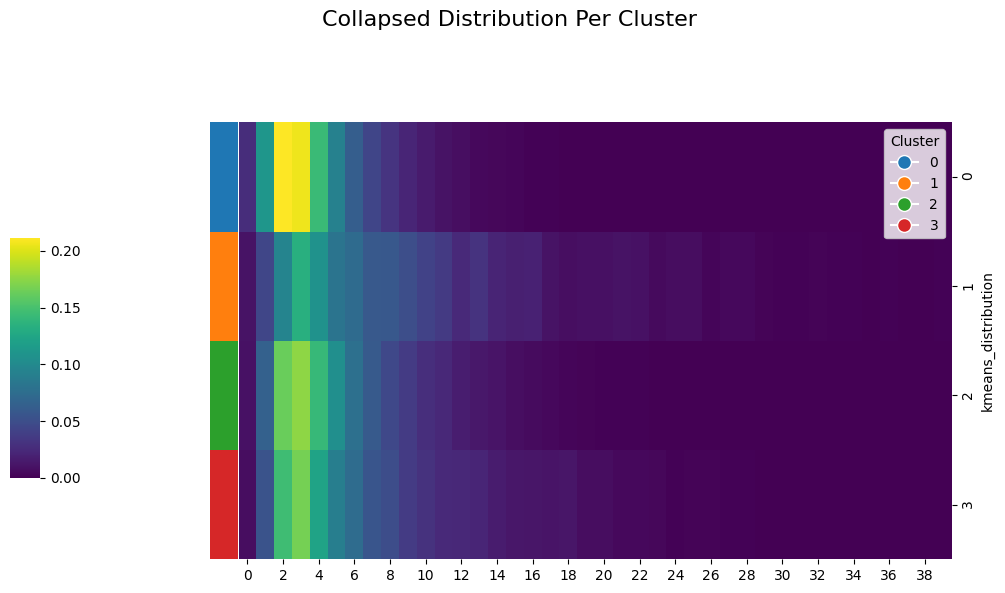

In [10]:
troutpy.pl.global_distribution_from_source(sdata, 
                               cluster_key= "kmeans_distribution", 
                               feature_key = "feature_name", 
                               distance_key= "distance", 
                               n_bins= 40, 
                               how= "collapsed")

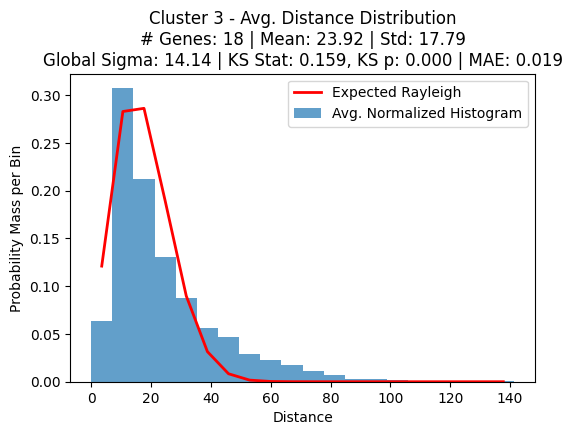

In [14]:
troutpy.pl.distributions_by_cluster(sdata,groups=[3])


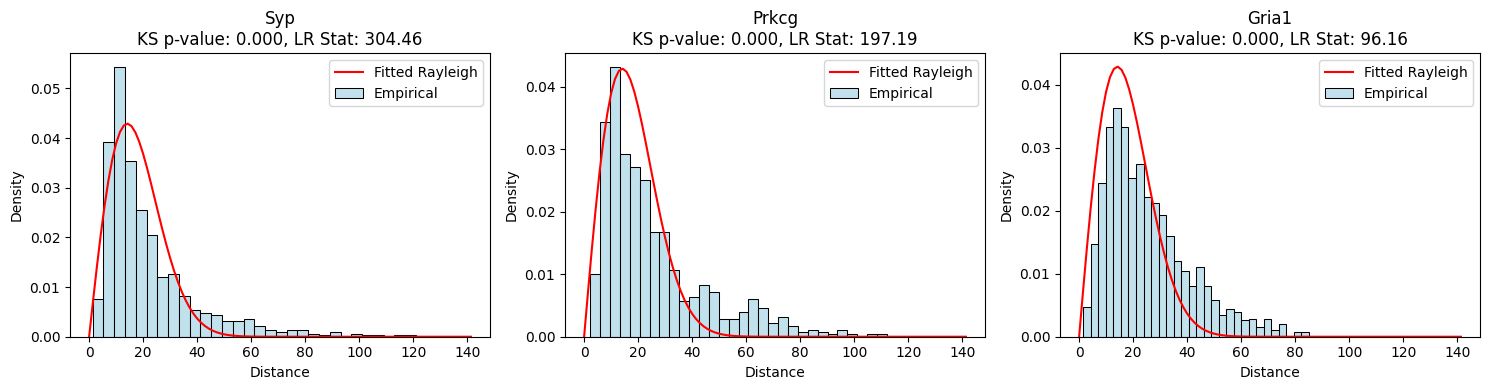

In [15]:
cool_pattern_df=sdata['xrna_metadata'].var[sdata['xrna_metadata'].var['kmeans_distribution']==3.0]
selected_genes=cool_pattern_df.sort_values(by='count',ascending=False).index
troutpy.pl.gene_distribution_from_source(sdata,selected_genes[0:3])

In [17]:
selected_genes

Index(['Syp', 'Prkcg', 'Gria1', 'Ptk2b', 'Grin1', 'Grin2a', 'Slc25a22',
       'Frrs1l', 'Ina', 'Cdk5r1', 'Gabra1', 'Lingo1', 'Plppr4', 'Tppp',
       'Gap43', 'Nrn1', 'Galnt17', 'Homer1'],
      dtype='object')

# Intra vs extracellular distribution

In [18]:
troutpy.tl.compare_intra_extra_distribution(sdata,copy=False)

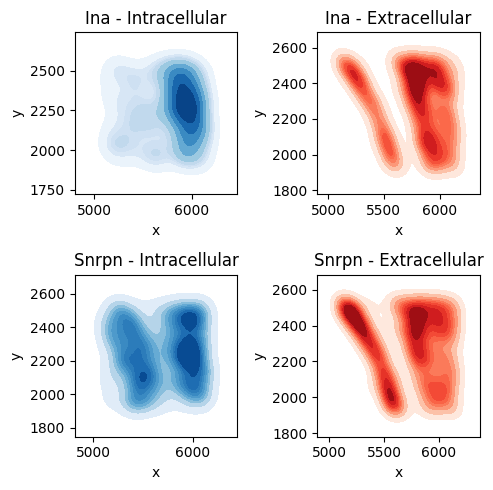

In [19]:
troutpy.pl.intra_extra_density(
    sdata, ['Ina','Snrpn'], layer="transcripts", gene_key="feature_name", coord_keys=["x", "y"],
    intra_kde_kwargs=None, extra_kde_kwargs=None,figsize=(5,5)
)